<a href="https://colab.research.google.com/github/salehafzoon/PA_on_Bone/blob/main/Paper_PA_on_Bone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Role of Physical Activity on Bone Mineral Density 

## Import Packages

In [ ]:
!pip install shap
# !pip install pingouin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from statsmodels.stats.stattools import durbin_watson
import statsmodels.stats.api as sms 
from statsmodels.compat import lzip
import shap
# import pingouin as pg
import scipy.stats as ss
# import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 6.4 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%matplotlib notebook 

## Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_excel(r"/content/drive/MyDrive/PA on Bone/DATABASE v5.xlsx",sheet_name='DATABASE')

print(data.shape)
data.columns

(10175, 18)


Index(['Bone_Density', 'Gender', 'Age', 'Ethnic', 'SistolicBP', 'DiastolicBP',
       'Mass', 'Height', 'GripStrength', 'CholesterolHDL', 'CholesterolTOT',
       'Estrogene', 'SexHormoneBindingGlobuline', 'Calcium_urine',
       'VitamineD_Blood', 'Vigorous_Int_min', 'Sum_Control_hours',
       'Total_Acc'],
      dtype='object')

First approach

In [ ]:
col =  ['Bone_Density', 'Gender', 'Age', 'Ethnic',
       'Mass', 'GripStrength', 'Vigorous_Int_min', 'Sum_Control_hours', 'Total_Acc']

In [ ]:
data = data[col]
print(data.shape)
data = data[data['Gender'] == 2]
print(data.shape)
data = data[data['Age'] < 80]
print(data.shape)
data = data[data['Sum_Control_hours'] > 8]
print(data.shape)
data = data[data['Ethnic'] != 7]
#data = data[data['Ethnic'] != 2]
print(data.shape)
data = data.replace([np.inf, - np.inf], np.nan)
data = data.dropna()
print(data.shape)
data = data[data['GripStrength'] > 0]
print(data.shape)

(10175, 9)
(5172, 9)
(4981, 9)
(1358, 9)
(1330, 9)
(1257, 9)
(1180, 9)


Second Approach

In [ ]:
col =  ['Bone_Density', 'Gender', 'Age', 'Ethnic',
       'Mass', 'GripStrength', 'Vigorous_Int_min', 'Sum_Control_hours', 'Total_Acc']

In [ ]:
data = data[col]
print(data.shape)
data = data[data['Gender'] == 2]
print(data.shape)
data = data[data['Age'] < 80]
print(data.shape)
data = data[data['Sum_Control_hours'] > 8]
print(data.shape)
data = data[data['Ethnic'] != 7]
#data = data[data[‘Ethnic’] != 2]
print(data.shape)
data = data.replace([np.inf, - np.inf], np.nan)
data = data.dropna()
print(data.shape)
data = data[data['GripStrength'] > 0]
print(data.shape)

(10175, 9)
(5172, 9)
(4981, 9)
(1358, 9)
(1330, 9)
(1257, 9)
(1180, 9)


In [ ]:
type(data)

pandas.core.frame.DataFrame

## Analysis of Bone Mineral Density Differences among Ethnicity

In [ ]:
pg.normality(data=data, dv='Bone_Density', group='Ethnic', method='normaltest')

W      pval  normal
3  25.891909  0.000002   False
6   8.219924  0.016408   False
4   1.720579  0.423040    True
2   8.088281  0.017525   False
1   4.066049  0.130939    True

In [ ]:
pg.kruskal(data=data, dv='Bone_Density', between='Ethnic')

Source  ddof1           H         p-unc
Kruskal  Ethnic      4  110.728869  5.087880e-23

In [ ]:
pg.pairwise_ttests(data=data, dv='Bone_Density', between='Ethnic', parametric=False)

pairwise_ttests is deprecated, use pairwise_tests instead.


Contrast  A  B  Paired  Parametric    U-val alternative         p-unc  \
0   Ethnic  1  2   False       False   8015.5   two-sided  4.352079e-01   
1   Ethnic  1  3   False       False  41876.0   two-sided  4.880175e-01   
2   Ethnic  1  4   False       False  11108.0   two-sided  4.571441e-10   
3   Ethnic  1  6   False       False  11758.5   two-sided  1.929623e-02   
4   Ethnic  2  3   False       False  33908.5   two-sided  1.012734e-01   
5   Ethnic  2  4   False       False   8771.5   two-sided  6.268990e-08   
6   Ethnic  2  6   False       False   9435.0   two-sided  3.131171e-03   
7   Ethnic  3  4   False       False  37258.0   two-sided  2.833778e-21   
8   Ethnic  3  6   False       False  41348.5   two-sided  2.784034e-02   
9   Ethnic  4  6   False       False  24644.0   two-sided  9.160990e-17   

     hedges  
0 -0.088078  
1  0.079613  
2 -0.666901  
3  0.285559  
4  0.172093  
5 -0.594587  
6  0.388734  
7 -0.795130  
8  0.214097  
9  0.941291

In [ ]:
data.describe()

Bone_Density  Gender          Age       Ethnic         Mass  \
count   1180.000000  1180.0  1180.000000  1180.000000  1180.000000   
mean       0.756765     2.0    56.755932     3.199153    75.970085   
std        0.141004     0.0    10.816368     1.342904    19.234658   
min        0.413000     2.0    40.000000     1.000000    39.800000   
25%        0.657000     2.0    47.000000     3.000000    62.475000   
50%        0.742000     2.0    56.000000     3.000000    72.750000   
75%        0.846250     2.0    66.000000     4.000000    86.600000   
max        1.277000     2.0    79.000000     6.000000   173.600000   

       GripStrength  Vigorous_Int_min  Sum_Control_hours     Total_Acc  
count   1180.000000       1180.000000        1180.000000   1180.000000  
mean      54.636356         96.667868          14.340056  13169.057679  
std       11.392396         69.513932           1.653563   3550.563427  
min       14.800000          0.281602           8.066486   3552.800022  
25%       47.300000         46.258215          13.553641  10798.076829  
50%       54.650000         81.737163          14.637521  12924.052213  
75%       62.000000        128.564448          15.463185  15355.544515  
max       93.200000        442.476704          18.149280  30737.758199

In [ ]:
means = data.groupby('Ethnic').mean()

In [ ]:
stds = data.groupby('Ethnic').std()

In [ ]:
data_Ethnic = data.groupby(['Ethnic'])['Bone_Density'].mean()
yerr = np.array(stds['Bone_Density'])
data_Ethnic.plot(kind='bar', yerr=yerr, fontsize=14, color='#00688B', error_kw=dict(lw=3, capsize=4, capthick=2), width= 0.8)
plt.ylabel('Bone Mineral Density (gm/cm2)', fontsize=16)
plt.xlabel('Ethnicity', fontsize=16)
plt.xticks([0, 1, 2, 3, 4], ['MA', 'OH', 'NHW', 'NHB', 'NHA'], rotation=0, fontsize=14)
plt.ylim([0, 1.1])

<IPython.core.display.Javascript object>

(0.0, 1.1)

In [ ]:
Ethnicy = 4
if Ethnicy != 0:
    data = data[data['Ethnic'] == Ethnicy]

In [ ]:
means

Bone_Density  Gender        Age       Mass  GripStrength  \
Ethnic                                                             
1           0.744933     2.0  54.818792  75.911409     51.028188   
2           0.756579     2.0  56.991228  72.431579     52.273684   
3           0.734605     2.0  57.926199  76.580996     54.354244   
4           0.842653     2.0  56.087866  84.632636     60.283682   
6           0.707265     2.0  55.191176  61.342647     51.769853   

        Vigorous_Int_min  Sum_Control_hours     Total_Acc  
Ethnic                                                     
1             119.585491          14.727134  14484.255412  
2             126.683863          14.815272  14804.091905  
3              91.611411          14.104886  12656.320147  
4              76.212703          14.461877  12582.205260  
6             102.497540          14.240780  13432.315814

In [ ]:
stds

Bone_Density  Gender        Age       Mass  GripStrength  \
Ethnic                                                             
1           0.135917     0.0  10.284503  17.377749     11.040234   
2           0.126310     0.0  10.377388  17.399045     11.449257   
3           0.127795     0.0  11.195048  18.419179     10.436239   
4           0.152312     0.0  10.365820  20.987612     12.479958   
6           0.126612     0.0  10.537070  12.248741      9.743414   

        Vigorous_Int_min  Sum_Control_hours    Total_Acc  
Ethnic                                                    
1              77.628546           1.348710  3668.740474  
2              93.873170           1.392641  3931.845148  
3              64.008251           1.638991  3386.807714  
4              56.548405           1.885723  3265.277008  
6              62.803857           1.616581  3425.736543

## Linear Relationship for Physical Activity and Sedentarism

In [ ]:
vect = ['Age', 'Mass', 'GripStrength', 'Vigorous_Int_min', 'Total_Acc']

rs = np.zeros(len(vect), object)
ps = np.zeros(len(vect), object)

for ii in range(0, len(vect)):
    rs[ii] = ss.pearsonr(x=data[vect[ii]], y=data['Bone_Density'])[0]
    ps[ii] = ss.pearsonr(x=data[vect[ii]], y=data['Bone_Density'])[1]

In [ ]:
# r = {'Age': [rs[0], ps[0]], 'Mass': [rs[1], ps[1]], 'Height': [rs[2], ps[2]], 'GripStrength': [rs[3], ps[3]], 
#      'Estrogen': [rs[4], ps[4]], 'Vigorous_Int_min': [rs[5], ps[5]], 
#                                                       'Total_Acc': [rs[6], ps[6]], 'BMI': [rs[7], ps[7]]}

# r = pd.DataFrame(r, index=['r', 'p'])
# r
r = {'Age': [rs[0], ps[0]], 'Mass': [rs[1], ps[1]], 'GripStrength': [rs[2], ps[2]],
     'Vigorous_Int_min': [rs[3], ps[3]], 'Total_Acc': [rs[4], ps[4]]}
r = pd.DataFrame(r, index=['r', 'p'])
r

Age          Mass  GripStrength  Vigorous_Int_min  Total_Acc
r -4.109884e-01  4.794846e-01      0.288069          0.089699   0.069256
p  3.714988e-11  3.827474e-15      0.000006          0.166903   0.286268

In [ ]:
#sns.pairplot(data[['Bone_Density', 'Age', 'Mass', 'Ethnic', 'Total_Acc', 'Vigorous_Int_min']], hue="Ethnic")

Due to the linear analysis, only the independent variables Age, Mass, Total_Acc, and Vigourous Intensity will be used.

## Split data

In [ ]:
act_var = 0

if act_var == 0:

    X = data[['Age', 'Mass', 'GripStrength', 'Total_Acc']]
    y = data[['Bone_Density']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    
elif act_var == 1:

    X = data[['Age', 'Mass', 'GripStrength']] #, 'Vigorous_Int_min']]
    y = data[['Bone_Density']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

## Scaling Up Features

In [ ]:
scaler = preprocessing.StandardScaler()
sX_train = scaler.fit_transform(X_train)
sX_test = scaler.transform(X_test)

## Model

In [ ]:
linear_model = LinearRegression()
linear_model.fit(sX_train, y_train)

LinearRegression()

In [ ]:
coefs = pd.DataFrame(index=X.columns)
coefs["coef"] = [linear_model.coef_[:,ii] for ii in range(0, linear_model.coef_.shape[1])]
coefs.loc['Intercept'] = linear_model.intercept_
coefs

coef
Age             [-0.05080881880307195]
Mass             [0.06428301714450838]
GripStrength  [-0.0008028666948035265]
Total_Acc        [0.01507904343063807]
Intercept                     0.841665

## Cross-Validation

In [ ]:
scores = cross_val_score(linear_model, sX_train, y_train, scoring='r2', cv=4)
scores

array([0.1914719 , 0.42343428, 0.36863541, 0.12477792])

## Predict

In [ ]:
linear_predictions_train = linear_model.predict(sX_train)
linear_predictions_test = linear_model.predict(sX_test)

## Model Evaluation

### Variance Explained

In [ ]:
r2_train = np.round(linear_model.score(sX_train, y_train), 3)
print('R^2_train: {0}'.format(r2_train))
r2_test = np.round(linear_model.score(sX_test, y_test), 3)
print('R^2_test: {0}'.format(r2_test))

R^2_train: 0.346
R^2_test: 0.407


### Mean Squared Error

In [ ]:
mse_train = np.round(mean_squared_error(y_train, linear_predictions_train), 3)
print('MSE_train: {0}'.format(mse_train))
mse_test = np.round(mean_squared_error(y_test, linear_predictions_test), 3)
print('MSE_test: {0}'.format(mse_test))

MSE_train: 0.014
MSE_test: 0.016


### Residuals Analysis

In [ ]:
residuals_train = {'Actual_train': np.array(y_train).flatten(), 'Predicted_train': linear_predictions_train.flatten()}
residuals_train = pd.DataFrame(residuals_train)
residuals_train['Residuals'] = abs(residuals_train['Actual_train']) - abs(residuals_train['Predicted_train'])

residuals_test = {'Actual_test': np.array(y_test).flatten(), 'Predicted_test': linear_predictions_test.flatten()}
residuals_test = pd.DataFrame(residuals_test)
residuals_test['Residuals'] = abs(residuals_test['Actual_test']) - abs(residuals_test['Predicted_test'])

#### Autocorrelation of residuals

In [ ]:
print(durbin_watson(residuals_train['Residuals'])) 
print(durbin_watson(residuals_test['Residuals'])) 

2.0740658084058445
1.7979238457587308


#### Normal Distribution of residuals

In [ ]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
t_train = sms.jarque_bera(residuals_train['Residuals'])
print(lzip(name, t_train))

t_test = sms.jarque_bera(residuals_test['Residuals'])
print(lzip(name, t_test))

[('Jarque-Bera', 6.787915195477127), ('Chi^2 two-tail prob.', 0.03357553515062553), ('Skew', 0.46167421417650284), ('Kurtosis', 2.9810413035971255)]
[('Jarque-Bera', 4.87185609524916), ('Chi^2 two-tail prob.', 0.08751648987808497), ('Skew', 0.7742520738152935), ('Kurtosis', 3.1950972895645893)]


#### Homoscedasticity

In [ ]:
residuals_train.plot.scatter(x='Predicted_train', y='Residuals', color='black')
plt.hlines(0, 0.5, 1.1, 'r')
print('Mean residuals = ', np.mean(residuals_train['Residuals']))

<IPython.core.display.Javascript object>

Mean residuals =  -1.6275520779845225e-17


In [ ]:
residuals_test.plot.scatter(x='Predicted_test', y='Residuals', color='black')
plt.hlines(0, 0.5, 1.1, 'r')
print('Mean residuals = ', np.mean(residuals_test['Residuals']))

<IPython.core.display.Javascript object>

Mean residuals =  -0.0025656000127703728


In [ ]:
# heteroscedasticity
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(np.array(residuals_train['Residuals']), sX_train)
lzip(name, test)

[('F statistic', 0.9383182605511402), ('p-value', 0.6191469093124289)]

In [ ]:
# heteroscedasticity
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(np.array(residuals_test['Residuals']), sX_test)
lzip(name, test)

[('F statistic', 1.986815895007303), ('p-value', 0.06658035702769327)]

#### Multicollinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame(index=X.columns)
vif["VIF Factor"] = [variance_inflation_factor(sX_train, ii) for ii in range(sX_train.shape[1])]
vif

VIF Factor
Age             1.173558
Mass            1.117955
GripStrength    1.220131
Total_Acc       1.105298

## Overall Analysis and other Machine Learning Options

### Overall linear regression

In [ ]:
residuals_train.plot.scatter(x='Predicted_train', y='Actual_train', color='black')
p1 = max(max(residuals_train['Predicted_train']), max(residuals_train['Actual_train']))
p2 = min(min(residuals_train['Predicted_train']), min(residuals_train['Actual_train']))
plt.plot([p1, p2], [p1, p2], 'r--', linewidth=3)
plt.text(min(residuals_train['Predicted_train']), max(residuals_train['Actual_train'])-0.1, 
         '$R^2$ =' + str(r2_train), fontsize=12, fontweight='bold')
m, b = np.polyfit(residuals_train['Predicted_train'], residuals_train['Actual_train'], 1)
plt.plot(residuals_train['Predicted_train'], m*residuals_train['Predicted_train']+b, 'b', linewidth=3)

<IPython.core.display.Javascript object>

In [ ]:
residuals_test.plot.scatter(x='Predicted_test', y='Actual_test', color='black', s=30)
p1 = max(max(residuals_test['Predicted_test']), max(residuals_test['Actual_test']))
p2 = min(min(residuals_test['Predicted_test']), min(residuals_test['Actual_test']))
plt.plot([p1, p2], [p1, p2], 'r--', linewidth=3)
plt.text(min(residuals_test['Predicted_test']), max(residuals_test['Actual_test'])-0.1, 
         '$R^2$ =' + str(r2_test), fontsize=12, fontweight='bold')
m, b = np.polyfit(residuals_test['Predicted_test'], residuals_test['Actual_test'], 1)
plt.plot(residuals_test['Predicted_test'], m*residuals_test['Predicted_test']+b, 'b', linewidth=3)
plt.ylabel('Observed Values', fontsize=14)
plt.xlabel('Predicted Values', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

<IPython.core.display.Javascript object>

(array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4]),
 <a list of 11 Text major ticklabel objects>)

### SHAP Values

In [1]:
!pip install shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap

from google.colab import drive
drive.mount('/content/drive')

%matplotlib notebook 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 6.4 MB/s 
Mounted at /content/drive


In [2]:
df = pd.read_excel(r"/content/drive/MyDrive/PA on Bone/DATABASE v5.xlsx",sheet_name='DATABASE')

print(df.columns)
df.head(4)

Index(['Bone_Density', 'Gender', 'Age', 'Ethnic', 'SistolicBP', 'DiastolicBP',
       'Mass', 'Height', 'GripStrength', 'CholesterolHDL', 'CholesterolTOT',
       'Estrogene', 'SexHormoneBindingGlobuline', 'Calcium_urine',
       'VitamineD_Blood', 'Vigorous_Int_min', 'Sum_Control_hours',
       'Total_Acc'],
      dtype='object')


Bone_Density  Gender  Age  Ethnic  SistolicBP  DiastolicBP  Mass  Height  \
0           NaN       1   69       4  112.666667    74.000000  78.3   171.3   
1         0.815       1   54       3  157.333333    61.333333  89.5   176.8   
2           NaN       1   72       3  142.000000    82.000000  88.9   175.3   
3           NaN       1    9       3  104.666667    36.666667  32.2   137.3   

   GripStrength  CholesterolHDL  CholesterolTOT  Estrogene  \
0          55.2            65.0           167.0     14.800   
1          61.5            50.0           170.0     14.000   
2          91.0            60.0           126.0     26.500   
3          32.2            61.0           168.0      2.117   

   SexHormoneBindingGlobuline  Calcium_urine  VitamineD_Blood  \
0                       62.45            9.5             28.9   
1                       29.16            9.2             61.9   
2                       54.60            8.9            126.0   
3                      114.20            NaN             73.3   

   Vigorous_Int_min  Sum_Control_hours  Total_Acc  
0               NaN                0.0        NaN  
1               NaN                0.0        NaN  
2               NaN                0.0        NaN  
3               NaN                0.0        NaN

To output multiple subplots, the figure containing the passed axes is being cleared


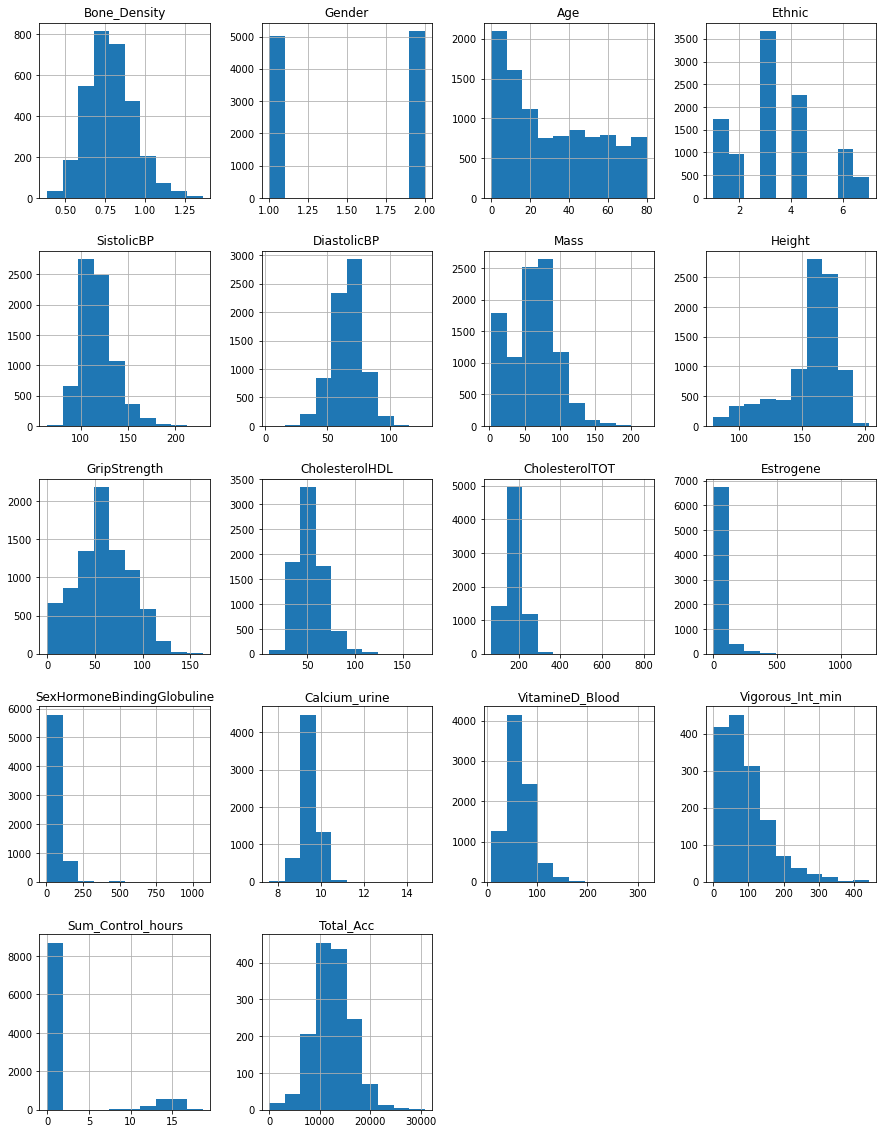

In [3]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.hist(ax = ax)

plt.savefig("/content/drive/MyDrive/PA on Bone/Plots/" +"raw_data_histogram.pdf",dpi=200,
              bbox_inches='tight')

In [ ]:
# col =  ['Bone_Density', 'Gender', 'Age', 'Ethnic',
#        'Mass', 'GripStrength', 'Vigorous_Int_min', 'Sum_Control_hours', 'Total_Acc']
       
# data = df[col]
# print(data.shape)
# data = data[data['Gender'] == 2]
# print(data.shape)
# data = data[data['Age'] < 80]
# print(data.shape)
# data = data[data['Sum_Control_hours'] > 8]
# print(data.shape)
# data = data[data['Ethnic'] != 7]
# #data = data[data['Ethnic'] != 2]
# print(data.shape)
# data = data.replace([np.inf, - np.inf], np.nan)
# data = data.dropna()
# print(data.shape)
# data = data[data['GripStrength'] > 0]
# print(data.shape)

(10175, 9)
(5172, 9)
(4981, 9)
(1358, 9)
(1330, 9)
(1257, 9)
(1180, 9)


In [4]:
feats = ['Age', 'Mass', 'GripStrength','Total_Acc','Ethnic','Gender','Sum_Control_hours']
target = 'Bone_Density'

data = df[feats +[target]]

data = data[data['Gender'] == 2]
data = data[data['Age'] < 80]
data = data[data['Sum_Control_hours'] > 8]
data = data[data['Ethnic'] != 7]
data = data.replace([np.inf, - np.inf], np.nan)
data = data.dropna()
data = data[data['GripStrength'] > 0]
print(data.shape)

data.head(10)

(1180, 8)


Age   Mass  GripStrength     Total_Acc  Ethnic  Gender  Sum_Control_hours  \
4    73   52.0          30.9   7292.593313       3       2          12.733521   
7    61   93.4          45.9  10725.330844       3       2          13.105849   
9    56   61.8          38.8  18438.607753       3       2          14.420565   
39   57  104.0          64.1   8787.818947       6       2          11.834833   
47   69   59.5          46.3   9980.986864       3       2          13.284891   
56   60  104.9          68.9  13342.070505       4       2          16.248806   
58   65   55.4          32.3  11650.574519       2       2          16.590217   
59   62   71.8          51.8  16392.099931       3       2          15.629849   
61   54   79.4          45.1  14702.996268       3       2          15.403510   
69   72   72.4          58.4  11622.069054       4       2          11.116319   

    Bone_Density  
4          0.722  
7          0.806  
9          0.657  
39         0.700  
47         0.595  
56         0.758  
58         0.807  
59         0.700  
61         0.705  
69         1.073

Correlation before NaN removal

In [5]:

# Correlation before NaN removal
print("\ndata shape before NaN removal:",data.shape,"\n")
print(data.isna().sum())
for f in feats:
  corr = data[target].corr(data[f])
  print ("Correlation between ", target, ",", f, ":", round(corr, 2))

# Correlation after NaN removal
data.dropna(axis='rows',inplace=True)
print("\ndata shape after NaN removal:",data.shape,"\n")
print(data.isna().sum())

for f in feats:
  corr = data[target].corr(data[f])
  print ("Correlation between ", target, ",", f, ":", round(corr, 2))

data.head(4)


data shape before NaN removal: (1180, 8) 

Age                  0
Mass                 0
GripStrength         0
Total_Acc            0
Ethnic               0
Gender               0
Sum_Control_hours    0
Bone_Density         0
dtype: int64
Correlation between  Bone_Density , Age : -0.43
Correlation between  Bone_Density , Mass : 0.49
Correlation between  Bone_Density , GripStrength : 0.4
Correlation between  Bone_Density , Total_Acc : 0.07
Correlation between  Bone_Density , Ethnic : 0.02
Correlation between  Bone_Density , Gender : nan
Correlation between  Bone_Density , Sum_Control_hours : 0.05

data shape after NaN removal: (1180, 8) 

Age                  0
Mass                 0
GripStrength         0
Total_Acc            0
Ethnic               0
Gender               0
Sum_Control_hours    0
Bone_Density         0
dtype: int64
Correlation between  Bone_Density , Age : -0.43
Correlation between  Bone_Density , Mass : 0.49
Correlation between  Bone_Density , GripStrength : 0.4
Corr

Age   Mass  GripStrength     Total_Acc  Ethnic  Gender  Sum_Control_hours  \
4    73   52.0          30.9   7292.593313       3       2          12.733521   
7    61   93.4          45.9  10725.330844       3       2          13.105849   
9    56   61.8          38.8  18438.607753       3       2          14.420565   
39   57  104.0          64.1   8787.818947       6       2          11.834833   

    Bone_Density  
4          0.722  
7          0.806  
9          0.657  
39         0.700

In [6]:
#0- all,1- , 2- , 3-white, 4- black, 6- Asian
ethnic_names = ['All', 'Mexican American', 'Other Hispanic', 'Non-Hispanic White',
                'Non-Hispanic Black', 'Non-Hispanic Asian'
                , 'Other Race'
                ]
ethnics_id = [0]
ethnics_id.extend(list(data['Ethnic'].unique()))
ethnics_id.sort()
print("ethnics_id:",ethnics_id)

data.groupby(["Ethnic"], as_index=False).count()

ethnics_id: [0, 1, 2, 3, 4, 6]


Ethnic  Age  Mass  GripStrength  Total_Acc  Gender  Sum_Control_hours  \
0       1  149   149           149        149     149                149   
1       2  114   114           114        114     114                114   
2       3  542   542           542        542     542                542   
3       4  239   239           239        239     239                239   
4       6  136   136           136        136     136                136   

   Bone_Density  
0           149  
1           114  
2           542  
3           239  
4           136

In [7]:
# i = 0 -> all data(all races)
ethnics_data = [data]

# i = 1 -> ....
for eth_id in ethnics_id[1:]:
  ethnics_data.append(data[(data.Ethnic == eth_id)])

(1180, 4)


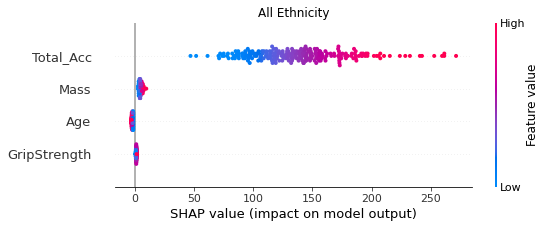

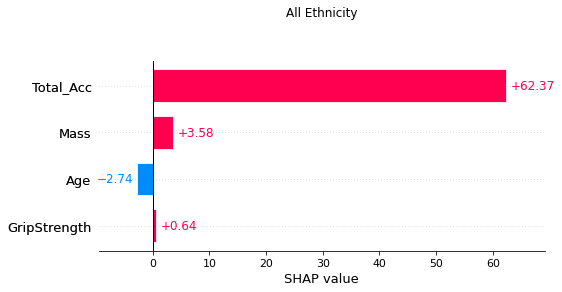

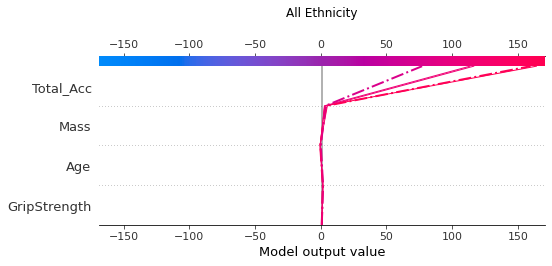

(149, 4)


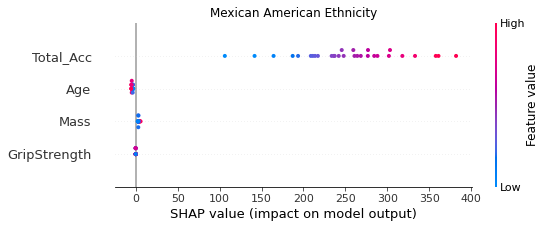

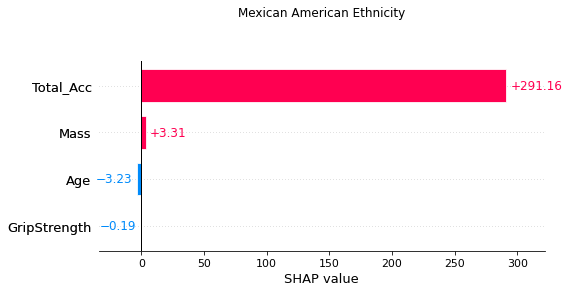

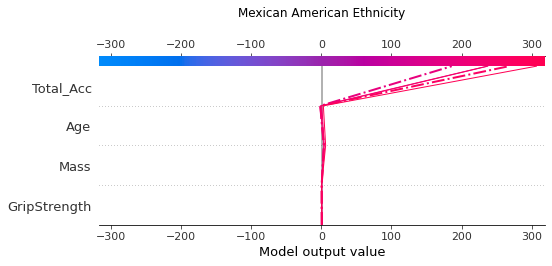

(114, 4)


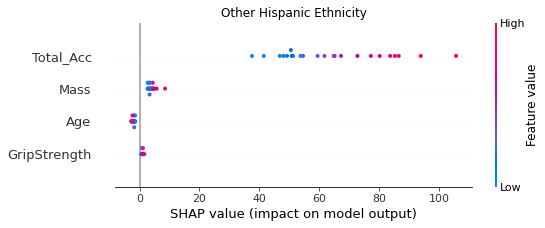

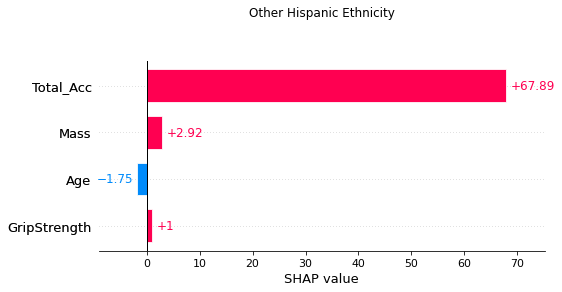

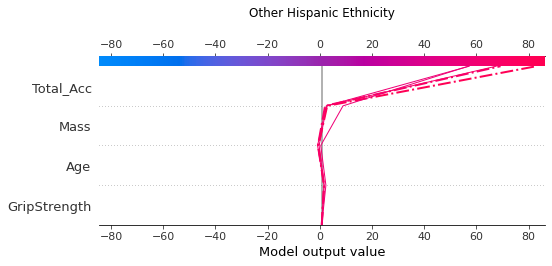

(542, 4)


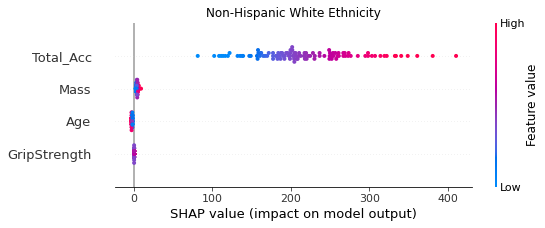

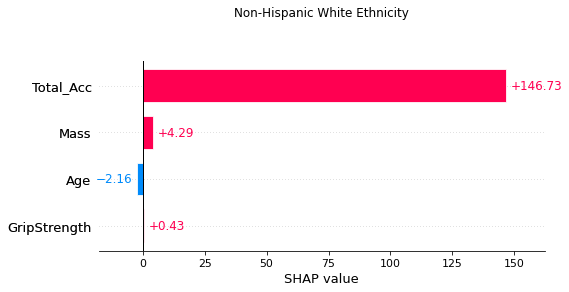

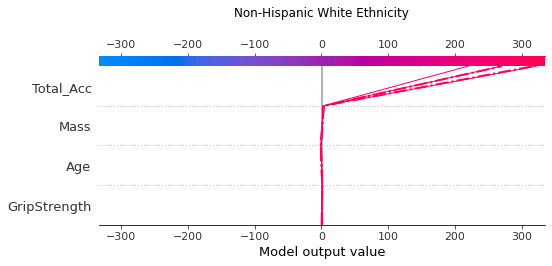

(239, 4)


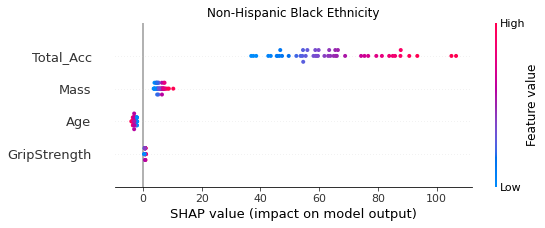

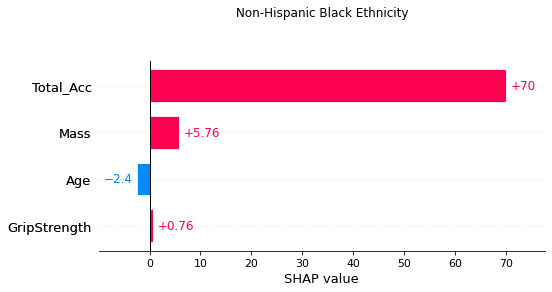

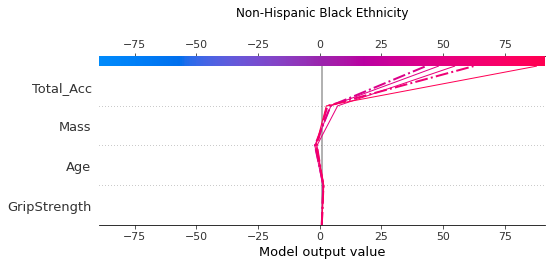

(136, 4)


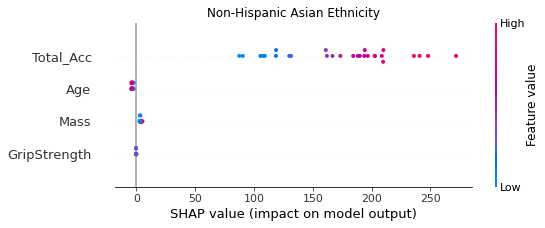

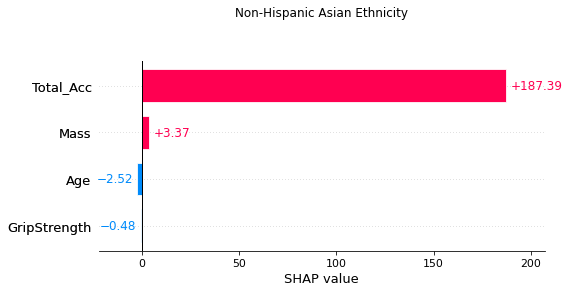

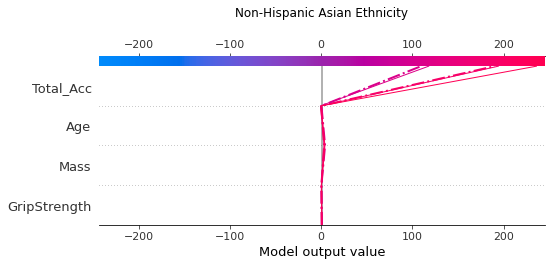

In [8]:
shap_plots_dir = '/content/drive/MyDrive/PA on Bone/Plots/SHAP/'

feature_names = ['Age', 'Mass', 'GripStrength']
target = 'Bone_Density'

act_var = 0
if act_var == 0:
  feature_names.append('Total_Acc');

model = LinearRegression()

for eth_data,eth_name in zip(ethnics_data, ethnic_names):
  
  print(eth_data[feature_names].shape)
  # data preparation
  X = eth_data[feature_names]
  y = eth_data[target]  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)  

  # preprocessing
  scaler = preprocessing.StandardScaler()
  sX_train = scaler.fit_transform(X_train)
  sX_test = scaler.transform(X_test)

  #model fitting
  model.fit(sX_train, y_train)

  shap.initjs()
  explainer = shap.LinearExplainer(model, sX_train)
  shap_values = explainer.shap_values(X_test)

  # summary plot
  shap.summary_plot(shap_values, X_test, show = False)
  plt.title(eth_name +" Ethnicity", y=1.2)
  plt.savefig(shap_plots_dir + "Summary plots/" + eth_name + "_act" + str(act_var) +"_summary_plot.pdf",dpi=200,
              bbox_inches='tight')
  plt.show()

  # bar plot
  shap.initjs()
  shap_values = explainer(X_train)
  shap.plots.bar(shap_values[4,:], show=False)
  plt.title(eth_name +" Ethnicity", y=1.2)
  plt.savefig(shap_plots_dir + "Bar plots/" + eth_name + "_act" + str(act_var) + "_bar_plot.pdf",dpi=200,
              bbox_inches='tight')
  plt.show()

  # decision plot
  shap.initjs()
  shap_values = explainer.shap_values(X_test)
  shap.decision_plot(explainer.expected_value, shap_values[5:10],feature_names = feature_names,
                   highlight=[1, 2], show=False)
  plt.title(eth_name +" Ethnicity", y=1.2)
  plt.savefig(shap_plots_dir + "Decision plots/" + eth_name + "_act" + str(act_var) +"_decision_plot.pdf",dpi=200,
              bbox_inches='tight')
  plt.show()


In [ ]:
# data preparation
X = ethnics_data[1][feature_names]
y = ethnics_data[1][target]  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)  

# preprocessing
scaler = preprocessing.StandardScaler()
sX_train = scaler.fit_transform(X_train)
sX_test = scaler.transform(X_test)

r = 5;
shap.initjs()
explainer = shap.LinearExplainer(model,X_train)

shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, show = False)
plt.title(ethnic_names[1] +" Ethnicity", y=1.2)
plt.savefig("Summary plots_" + ethnic_names[0] + "_act" + str(act_var) +"_summary_plot.pdf",dpi=200,
            bbox_inches='tight')
plt.show()

# shap.force_plot(explainer.expected_value, shap_values[r,:], X_test.iloc[r,:])

### Decision Tree Regressor

In [ ]:
dec_tree = DecisionTreeRegressor().fit(sX_train, y_train.values.flatten())
dec_tree_y_pred = dec_tree.predict(sX_test)
print("Mean squared error: %.4f" % mean_squared_error(y_test.values.flatten(), dec_tree_y_pred))
print("R squared: %.4f" % r2_score(y_true=y_test.values.flatten(),y_pred=dec_tree_y_pred))

### Random Forest Regressor

In [ ]:
rf_tree = RandomForestRegressor().fit(sX_train,y_train.values.flatten())
rf_tree_y_pred = rf_tree.predict(sX_test)
print("Mean squared error: %.4f" % mean_squared_error(y_test.values.flatten(), rf_tree_y_pred))
print("R squared: %.4f" % r2_score(y_true=y_test.values.flatten(),y_pred=rf_tree_y_pred))

### SVM regressor

In [ ]:
svr = SVR().fit(sX_train, y_train.values.flatten())
svr_y_pred = svr.predict(sX_test)
print("Mean squared error: %.4f" % mean_squared_error(y_test.values.flatten(), svr_y_pred))
print("R squared: %.4f" % r2_score(y_true=y_test.values.flatten(),y_pred=svr_y_pred))